# 91APP EDA

## 目的
利用資料視覺化分析資料

## 方法
利用python程式套件，使用pandas做資料處理、matplotlib與seaborn作圖

## 成果
- 一、各月份營業額走勢圖
- 二、營業額各縣市占比
- 三、各年齡區間男女總購買金額金字塔圖



In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import datetime

## 讀進Orders.csv和Member.csv

In [8]:
#Read Orders.csv
order_chunk=pd.read_csv('Orders.csv',chunksize=500000, iterator=True)
def order_chunk_preprocessing(chunk):
    a=chunk[['MemberId','UnitPrice', 'City', 'DateId']]
    return a
chunk_list = []
for chunk in order_chunk:
    chunk_filter = order_chunk_preprocessing(chunk)
    chunk_list.append(chunk_filter)  
order= pd.concat(chunk_list)
order.head()

,MemberId,UnitPrice,City,DateId
0,1388133,350.0,嘉義縣,20150703
1,1388133,199.0,嘉義縣,20150703
2,1388133,199.0,嘉義縣,20150703
3,1388133,225.0,嘉義縣,20150703
4,365787,100.0,桃園市,20150703


In [9]:
#Read Member.csv
member=pd.read_csv('Member.csv')
def birthday_to_age(string):
    a=datetime.datetime.strptime(string, '%Y-%m-%d').year
    a=2019-a
    if a<5 or a>90:
        return float('NaN')
    else:
        return a
def member_preprocessing(member):
    a=member[['MemberId','Birthday','GenderTypeDef']]
    a[['MemberId']]=a[['MemberId']].astype('int32')
    a=a.dropna()
    a=a[['MemberId','Birthday','GenderTypeDef']]
    a[['Birthday']]=a.Birthday.apply(birthday_to_age)
    a=a.dropna()
    a.rename(columns={'Birthday':'Age'}, inplace=True)
    return a
member=member_preprocessing(member)
member.head()

,MemberId,Age,GenderTypeDef
17,1588769,40.0,Female
71,1592258,39.0,Female
81,1593039,42.0,Female
343,1283358,40.0,Female
463,1287291,36.0,Female


## 一、各月份營業額走勢圖

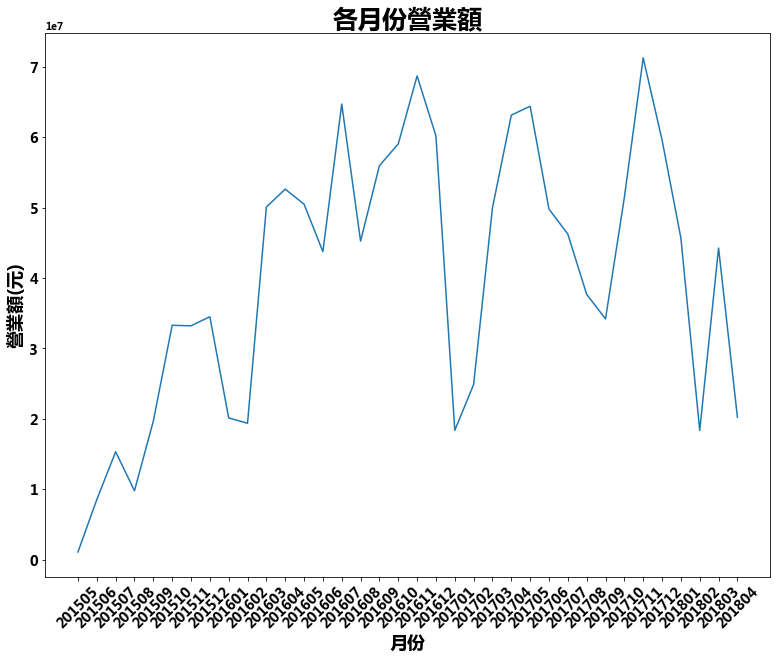

In [3]:
#Data Manipulation
def DateId_to_month(dateid):
    a=int((dateid-dateid%100)/100)
    b=str(a)
    return b
order['DateId']=order.DateId.apply(DateId_to_month)

plot_order=order.groupby('DateId')['UnitPrice'].sum()
plot_order=plot_order.to_frame()
plot_order.reset_index(inplace=True)


#plot
fig = plt.figure(figsize=(13, 10))
plt.plot(plot_order['DateId'], plot_order['UnitPrice'], '-')
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei'] 
plt.rcParams['axes.unicode_minus'] = False
plt.xlabel("月份",fontsize=18)
plt.xticks(fontsize=14,rotation=45)
plt.ylabel("營業額(元)",fontsize=18)
plt.yticks(fontsize=14)
plt.title("各月份營業額", fontsize=25)
plt.show()

這張圖顯示各月份的營業額走勢，有助於決策者判斷某些時段的行銷策略是否有效，並且做出相對應的策略來維持營業額，從走勢圖可以看出每年的10、11月左右是相對高峰，推測應該跟雙11業者推出促銷活動有關

## 二、總營業額各縣市占比

<Figure size 1080x1080 with 0 Axes>

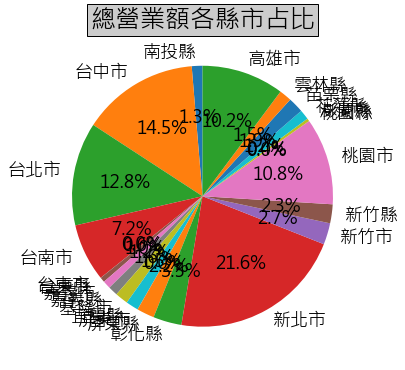

In [4]:
#Data Manipulation
plot_city=order.groupby("City")["UnitPrice"].sum()
city_list=[]
city_list=plot_city.keys()[21:]
city_list_value=plot_city[21:]

#plot
fig =plt.figure(figsize=(15, 15))
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size']=18.0
plt.figure(figsize=(8,6))
plt.pie(city_list_value, labels=city_list, autopct='%1.1f%%', startangle=90)
plt.title('總營業額各縣市占比',fontsize=25,bbox={'facecolor':'0.8', 'pad':3})
plt.show()

從此圓餅圖可以看出大部分的營業額來自六都地區，這可能和都市人口數有很大的關係

## 三、各年齡區間男女總購買金額金字塔圖

C:\Users\Vg6\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


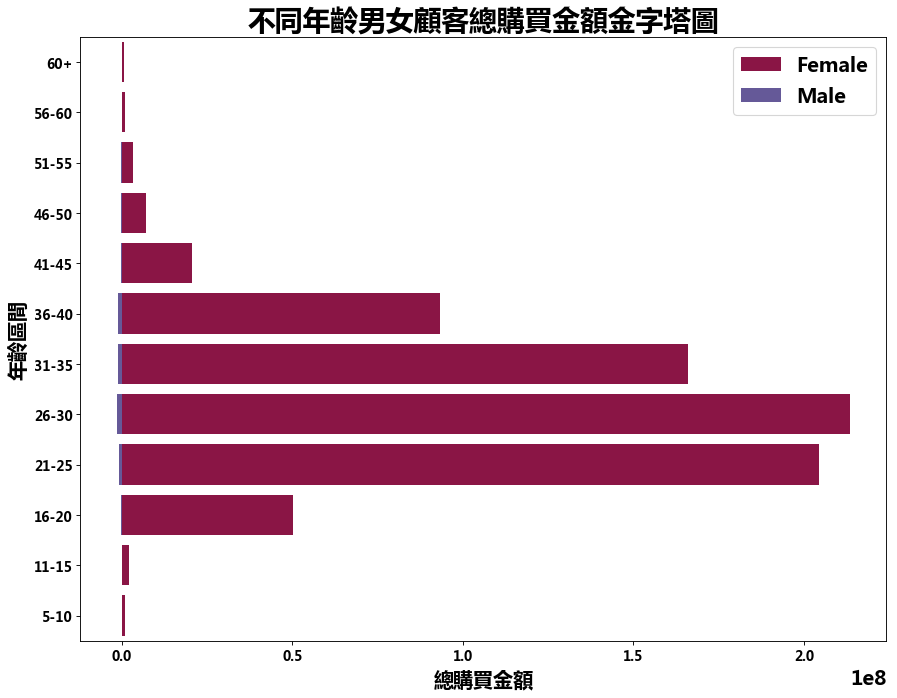

In [5]:
#資料整理、分類
member_unit_price=order.groupby('MemberId')["UnitPrice"].sum()
member_unit_price=member_unit_price.to_frame()

member_all=member_unit_price.join(member.set_index('MemberId'))
member_all=member_all.dropna()
member_all.reset_index(inplace=True)

bins=[4,11,16,21,26,31,36,41,46,51,56,61,100]
labels=['5-10','11-15','16-20','21-25','26-30','31-35','36-40','41-45','46-50','51-55','56-60','60+']
member_all['Age_range']=pd.cut(member_all.Age, bins, labels = labels,include_lowest = True)

member_age_range=member_all.groupby(['Age_range','GenderTypeDef'])['UnitPrice'].sum()
member_age_range=member_age_range.to_frame()
member_age_range.reset_index(inplace=True)
for i in range(len(member_age_range)):
    if member_age_range['GenderTypeDef'][i]=='Male':
        member_age_range['UnitPrice'][i]=member_age_range['UnitPrice'][i]*(-1)

#plot
plt.figure(figsize=(13,10), dpi= 80)
group_col = 'GenderTypeDef'
order_of_bars = member_age_range.Age_range.unique()[::-1]
colors = [plt.cm.Spectral(i/float(len(member_age_range[group_col].unique())-1)) 
            for i in range(len(member_age_range[group_col].unique()))]

for c, group in zip(colors, member_age_range[group_col].unique()):
    sns.barplot(x='UnitPrice', y='Age_range', 
                data=member_age_range.loc[member_age_range[group_col]==group, :], order=order_of_bars, color=c, label=group)

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei'] 
plt.rcParams['axes.unicode_minus'] = False
plt.xlabel("總購買金額",fontsize=18)
plt.xticks(fontsize=12)
plt.ylabel("年齡區間",fontsize=18)
plt.yticks(fontsize=12)
plt.title("不同年齡男女顧客總購買金額金字塔圖", fontsize=25)
plt.legend(fontsize=18)
plt.show()

從這個金字塔圖可以看出男女性顧客的比例非常懸殊，大多數網購者為女性，且網購用戶年齡約介於20~30歲。因此若在制定相關行銷策略時，可針對此一族群顧客加強行銷